##  作業

In [3]:
import pandas
google = pandas.read_excel('https://raw.githubusercontent.com/ywchiu/tibame_tm/master/data/google_comments.xlsx', index_col = 0)

In [4]:
google.head()

,username,score,comment
0,倪依芙,5,起初找不到入口，還以為沒座位，但是原來入口在旁邊樓梯～座位區不大，但是料理很好吃～肉圓的醬微...
1,Mimi龍,4,聞名已久，今天特別來現場試試，目前改成點餐機點餐， ⋯⋯更多聞名已久，今天特別來現場試試，目...
2,林昌逸,1,非常生氣服務員的態度😠服務很糟糕，麵都還沒吃完，一起身就把麵收走，擺明趕客人😡😡😡
3,林幸蓁,5,內用與外帶有不同的點餐方式內用須至店內使用機台點菜、輸入桌號並付款外帶好像只需在入口處點餐即...
4,台灣TAXI市區叫車禮車包車約拍找小鄭,5,乾淨衛生，廁所很大在地下室，有免費飲料可以喝，拉麵愛好吃，麻辣豆腐不錯、肉粽不錯，目前吃過很...


In [6]:
google['score'].value_counts()

1    160
5    147
4     92
3     60
2     41
Name: score, dtype: int64

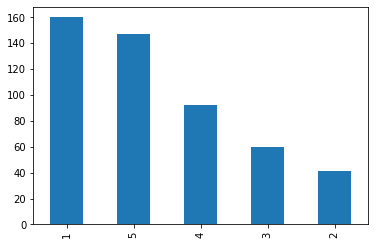

In [8]:
google['score'].value_counts().plot(kind = 'bar')

In [10]:
def convertScore(score):
  if score >= 4:
    return 'good'
  elif score == 3:
    return 'soso'
  else:
    return 'bad'

google['status'] = google['score'].map(lambda e: convertScore(e))

In [11]:
google.head()

,username,score,comment,status
0,倪依芙,5,起初找不到入口，還以為沒座位，但是原來入口在旁邊樓梯～座位區不大，但是料理很好吃～肉圓的醬微...,good
1,Mimi龍,4,聞名已久，今天特別來現場試試，目前改成點餐機點餐， ⋯⋯更多聞名已久，今天特別來現場試試，目...,good
2,林昌逸,1,非常生氣服務員的態度😠服務很糟糕，麵都還沒吃完，一起身就把麵收走，擺明趕客人😡😡😡,bad
3,林幸蓁,5,內用與外帶有不同的點餐方式內用須至店內使用機台點菜、輸入桌號並付款外帶好像只需在入口處點餐即...,good
4,台灣TAXI市區叫車禮車包車約拍找小鄭,5,乾淨衛生，廁所很大在地下室，有免費飲料可以喝，拉麵愛好吃，麻辣豆腐不錯、肉粽不錯，目前吃過很...,good


In [15]:
import jieba
corpus = []
tags = []
for idx, rec in google[google['status'].isin(['good', 'bad'])].iterrows():
  corpus.append(' '.join(jieba.cut(rec.get('comment'))))
  tags.append(rec.get('status'))

Building prefix dict from the default dictionary ...
Dumping model to file cache /tmp/jieba.cache
Loading model cost 0.954 seconds.
Prefix dict has been built successfully.


In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
tfidf = vectorizer.fit_transform(corpus)

In [17]:
x = tfidf
y = tags

In [18]:
from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y = train_test_split(x,y, test_size = 0.2, random_state = 42)

In [19]:
from sklearn.naive_bayes import MultinomialNB
clf1 = MultinomialNB(alpha = 0.01)
clf1.fit(train_x, train_y)

MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True)

In [20]:
from sklearn.svm import SVC
clf2 = SVC(kernel = 'linear')
clf2.fit(train_x, train_y)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [22]:
pred_y = clf1.predict(test_x)

In [23]:
from sklearn.metrics import accuracy_score
accuracy_score(test_y, pred_y)

0.8181818181818182

In [25]:
from sklearn.metrics import confusion_matrix
print(clf1.classes_)
confusion_matrix(test_y, pred_y)

['bad' 'good']


array([[30, 10],
       [ 6, 42]])

In [26]:
features_ary = []
for word, bad_count, good_count in zip(vectorizer.get_feature_names(), clf1.feature_count_[0], clf1.feature_count_[1]):
  dic = {}
  dic['good_ratio'] = good_count/(bad_count + 1)
  dic['bad_ratio'] = bad_count / (good_count + 1)
  dic['good_cnt'] = good_count
  dic['bad_cnt'] = bad_count
  dic['word'] = word
  features_ary.append(dic)

In [27]:
import pandas
features_df = pandas.DataFrame(features_ary)

In [30]:
features_df.sort_values('good_ratio', ascending=False).head(10)

,good_ratio,bad_ratio,good_cnt,bad_cnt,word
971,4.432004,0.155759,16.540930,2.732156,好吃
12,4.281420,0.016871,4.692600,0.096038,24
1041,4.281420,0.016871,4.692600,0.096038,小時
2189,4.264247,0.018926,4.726398,0.108378,親切
973,4.072805,0.049346,5.348771,0.313289,好喝
2050,3.478154,0.067243,4.845260,0.393055,美味
2053,3.343670,0.026732,3.770038,0.127515,美食
2606,3.150396,0.073043,4.390926,0.393770,飲料
340,3.121750,0.085690,4.626977,0.482174,乾意
302,3.112518,0.115085,5.407819,0.737442,不錯


In [31]:
features_df.sort_values('bad_ratio', ascending=False).head(10)

,good_ratio,bad_ratio,good_cnt,bad_cnt,word
1247,0.129321,3.228117,0.938621,6.258093,態度
1004,0.101876,2.808830,0.543576,4.335644,客人
1130,0.000000,2.552051,0.000000,2.552051,店員態度
1439,0.050667,2.548792,0.206472,3.075046,普通
1924,0.049725,2.343325,0.188173,2.784275,知道
1974,0.000000,2.227581,0.000000,2.227581,第二次
293,0.051669,2.202086,0.186692,2.613197,不要
2483,0.000000,2.158271,0.000000,2.158271,重點
270,0.155664,2.059802,0.701101,3.503932,不會
2155,0.000000,2.035631,0.000000,2.035631,蟑螂


In [32]:
pred_y = clf2.predict(test_x)

In [33]:
accuracy_score(test_y, pred_y)

0.875

In [34]:
confusion_matrix(test_y, pred_y)

array([[33,  7],
       [ 4, 44]])

## Synset

In [36]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [37]:
from nltk.corpus import wordnet as wn
wn.synsets('motorcar')

[Synset('car.n.01')]

In [39]:
wn.synsets('trunk')

[Synset('trunk.n.01'),
 Synset('trunk.n.02'),
 Synset('torso.n.01'),
 Synset('luggage_compartment.n.01'),
 Synset('proboscis.n.02')]

In [40]:
wn.synset('car.n.01').lemma_names()

['car', 'auto', 'automobile', 'machine', 'motorcar']

## 計數手法

In [62]:
a = '''
def ppmi(C, verbose=False, eps = 1e-8):
    M = np.zeros_like(C, dtype=np.float32)
    N = np.sum(C)
    S = np.sum(C, axis=0)
    total = C.shape[0] * C.shape[1]
    cnt = 0
    for i in range(C.shape[0]):
        for j in range(C.shape[1]):
            pmi = np.log2(C[i, j] * N / (S[j]*S[i]) + eps)
            M[i, j] = max(0, pmi)
            if verbose:
                cnt += 1
                if cnt % (total//100) == 0:
                    print('%.1f%% done' % (100*cnt/total))
    return M




'''

print(a.replace('\xa0', ' '))


def ppmi(C, verbose=False, eps = 1e-8):
    M = np.zeros_like(C, dtype=np.float32)
    N = np.sum(C)
    S = np.sum(C, axis=0)
    total = C.shape[0] * C.shape[1]
    cnt = 0
    for i in range(C.shape[0]):
        for j in range(C.shape[1]):
            pmi = np.log2(C[i, j] * N / (S[j]*S[i]) + eps)
            M[i, j] = max(0, pmi)

            if verbose:
                cnt += 1
                if cnt % (total//100) == 0:
                    print('%.1f%% done' % (100*cnt/total))
    return M







In [46]:
import numpy as np
def preprocess(text):
    text = text.lower()
    text = text.replace('.', ' .')
    words = text.split(' ')
    word_to_id = {}
    id_to_word = {}
    for word in words:
        if word not in word_to_id:
            new_id = len(word_to_id)
            word_to_id[word] = new_id
            id_to_word[new_id] = word
    corpus = np.array([word_to_id[w] for w in words])
    return corpus, word_to_id, id_to_word

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

In [48]:
corpus

array([0, 1, 2, 3, 4, 1, 5, 6])

In [50]:
word_to_id

{'.': 6, 'and': 3, 'goodbye': 2, 'hello': 5, 'i': 4, 'say': 1, 'you': 0}

In [51]:
id_to_word

{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}

In [53]:
def create_co_matrix(corpus, vocab_size, window_size=1):
    corpus_size = len(corpus)
    co_matrix = np.zeros((vocab_size, vocab_size), dtype=np.int32)

    for idx, word_id in enumerate(corpus):
        for i in range(1, window_size + 1):
            left_idx = idx - i
            right_idx = idx + i

            if left_idx >= 0:
                left_word_id = corpus[left_idx]
                co_matrix[word_id, left_word_id] += 1

            if right_idx < corpus_size:
                right_word_id = corpus[right_idx]
                co_matrix[word_id, right_word_id] += 1

    return co_matrix

In [54]:
text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(word_to_id)
vocab_size

7

In [56]:
print(word_to_id.keys())
C = create_co_matrix(corpus, vocab_size)
C

dict_keys(['you', 'say', 'goodbye', 'and', 'i', 'hello', '.'])


array([[0, 1, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 1, 1, 0],
       [0, 1, 0, 1, 0, 0, 0],
       [0, 0, 1, 0, 1, 0, 0],
       [0, 1, 0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1, 0]], dtype=int32)

In [59]:
from sklearn.metrics.pairwise import cosine_similarity
def most_similar(query, word_to_id, id_to_word, word_matrix, top=5):
    # 1. 列出Query
    if query not in word_to_id:
        print('%s is not found' % query)
        return
    print('[query] ' + query)
    query_id = word_to_id[query]
    query_vec = word_matrix[query_id]
    
    # 2. 計算Cosine Similarity
    vocab_size = len(id_to_word)
    similarity = np.zeros(vocab_size)
    for i in range(vocab_size):
        similarity[i] = cosine_similarity([word_matrix[i], query_vec])[1,0]
        
    # 3. 從cosine similarity 由高到低列出數值結果
    count = 0
    for i in (-1 * similarity).argsort():
        if id_to_word[i] == query:
            continue
        print(' %s: %s' % (id_to_word[i], similarity[i]))
        count += 1
        if count >= top:
            return


In [60]:
most_similar('you', word_to_id, id_to_word, C, top=5)

[query] you
 goodbye: 0.7071067811865475
 i: 0.7071067811865475
 hello: 0.7071067811865475
 say: 0.0
 and: 0.0


In [61]:
most_similar('i', word_to_id, id_to_word, C, top=5)

[query] i
 goodbye: 0.9999999999999998
 you: 0.7071067811865475
 hello: 0.4999999999999999
 say: 0.0
 and: 0.0


In [63]:
def ppmi(C, verbose=False, eps = 1e-8):
    M = np.zeros_like(C, dtype=np.float32)
    N = np.sum(C)
    S = np.sum(C, axis=0)
    total = C.shape[0] * C.shape[1]
    cnt = 0
    for i in range(C.shape[0]):
        for j in range(C.shape[1]):
            pmi = np.log2(C[i, j] * N / (S[j]*S[i]) + eps)
            M[i, j] = max(0, pmi)

            if verbose:
                cnt += 1
                if cnt % (total//100) == 0:
                    print('%.1f%% done' % (100*cnt/total))
    return M

In [64]:
W = ppmi(C)

In [65]:
W

array([[0.       , 1.8073549, 0.       , 0.       , 0.       , 0.       ,
        0.       ],
       [1.8073549, 0.       , 0.8073549, 0.       , 0.8073549, 0.8073549,
        0.       ],
       [0.       , 0.8073549, 0.       , 1.8073549, 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 1.8073549, 0.       , 1.8073549, 0.       ,
        0.       ],
       [0.       , 0.8073549, 0.       , 1.8073549, 0.       , 0.       ,
        0.       ],
       [0.       , 0.8073549, 0.       , 0.       , 0.       , 0.       ,
        2.807355 ],
       [0.       , 0.       , 0.       , 0.       , 0.       , 2.807355 ,
        0.       ]], dtype=float32)

In [66]:
W.shape

(7, 7)

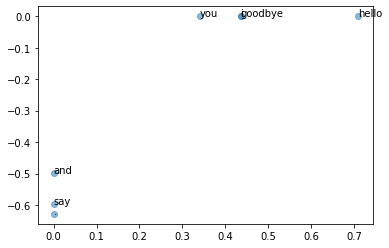

In [68]:
# SVD
U, S, V = np.linalg.svd(W)

# 繪製相對位置圖
from matplotlib import pyplot as plt
for word, word_id in word_to_id.items():
  plt.annotate(word, (U[word_id, 0], U[word_id, 1]))
plt.scatter(U[:,0], U[:,1], alpha=0.5)
plt.show()